In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
print(f'Current Step #01 [now = {datetime.now()}')


Current Step #01 [now = 2025-06-19 19:16:16.971869


In [5]:
results = {}

In [6]:
def lstm_predict(train_X, train_y, test_X):
    """ lstm_predict """
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(10, 1))) # 50 LSTM units
    model.add(Dense(1)) # Output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    # Train the model
    model.fit(train_X, train_y, epochs=100, verbose=0)
    # Make predictions
    X_test = np.random.rand(5, 10, 1)
    predictions = model.predict(test_X)
    return predictions

In [7]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    metrics = metrics[0].split('|')
    return metrics[0], metrics[1]


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    for i in rounds_str.split(','):
        rounds.append(int(i))
    for i in matched_cnts_str.split(','):
        matched_cnts.append(int(i))
    rounds.reverse()
    matched_cnts.reverse()
    df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
    return df


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [8]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


```python
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout,  Dense
from tensorflow.keras.regularizers import l1_l2, l2

total_words = 478
max_sequence_len = 90
model = Sequential()
Layer1 = model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
Layer2 = model.add(Bidirectional(LSTM(20, return_sequences=True)))
Layer3 = model.add(Dropout(.03))
Layer4 = model.add(LSTM(20))
Layer5 = model.add(Dense(total_words, 
    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=l2(1e-4),
    activity_regularizer=l2(1e-5)))
          # A Dense Layer including regularizers
Layer6 = model.add(Dense(total_words, activation = 'softmax'))
          
# Pick an optimizer
          
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
```

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example data
data = np.array([[1], [2], [3], [4], [5]])

# Initialize and fit-transform the scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Scaled Data:")
print(scaled_data)

# Restore the original data using inverse_transform
restored_data = scaler.inverse_transform(scaled_data)

print("\nRestored Data:")
print(restored_data)


Scaled Data:
[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]

Restored Data:
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]


In [38]:
### 최종 결과 입니다.
def analyze_v1(random_state, version, db_file_path, predict_round=7, predict_scale=10000000, verbose=0):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    verbose=0
    version = "T_01_11"
    db_file_path = '../db/metrics.db'
    random_state = 113789
    # random_state = 113700

    # 1. Prepare the Data
    # Create sample time series data
    # data = np.array([i for i in range(1, 101)]).reshape(-1, 1)
    df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
    if verbose > 0:
        print('df', df)
    print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # print('matched_cnts', df['matched_cnts'].values)
    # print('data', data)

    # Normalize the data
    # scaler = StandardScaler()
    # # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(data)
    scaled_data = np.array([[int(i[0]) / 10.0] for i in data])
    print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)
    sequence_length = 10

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.9)

    X_train, X_test, X_last = X[:train_size], X[train_size:], [y[-1:],]
    y_train, y_test = y[:train_size], y[train_size:]
    print(f'X_last = {X_last}')
    print(f'X_test = {X_test}, {type(X_test)}')
    print(f'Current Step #10 [now = {datetime.now()}]')

    tf.random.set_seed(random_state)

    # layer information
    layer_count = 3
    activation='sigmoid'
    units=50

    # 2. Build the LSTM Model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for i in range(layer_count):
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0) # verbose=0 for silent training
    model.fit(X_train, y_train, epochs=25, batch_size=1, verbose=0) # verbose=0 for silent training
    # model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training
    # model.fit(X_train, y_train, epochs=25, batch_size=1, verbose=0) # verbose=0 for silent training

    print(f'Current Step #14 [now = {datetime.now()}]')

    # 4. Make Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    last_predict = model.predict(y_test[-1:])
    print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    #   calculate min value
    # print('1, test_predict', test_predict)
    train_predict = np.array([[round(i[0], predict_round)] for i in train_predict])
    train_p_min = train_predict.min()
    test_predict = np.array([[round(i[0], predict_round)] for i in test_predict])
    last_predict = np.array([[round(i[0], predict_round)] for i in last_predict])
    # print('2, test_predict', test_predict)
    test_p_min = test_predict.min()
    if test_p_min > train_p_min:
        p_min = train_p_min
    else:
        p_min = test_p_min

    # print('p_min', p_min)
    #   inverse
    train_predict = np.array([[math.trunc(float((i[0] - p_min)*predict_scale))] for i in train_predict])
    test_predict = np.array([[math.trunc(float((i[0] - p_min)*predict_scale))] for i in test_predict])
    last_predict = np.array([[math.trunc(float((i[0] - p_min)*predict_scale))] for i in last_predict])
    # print('3, test_predict', test_predict)
    print(f'Current Step #17 [now = {datetime.now()}]')


    # 원본 데이터를 복원합니다.
    # Inverse original data
    y_train_original = np.array([[(i[0] * 10)] for i in y_train.reshape(-1, 1)])
    y_test_original = np.array([[(i[0] * 10)] for i in y_test.reshape(-1, 1)])
    # scaled_data = scaler.inverse_transform(scaled_data)
    scaled_data = np.array([[i[0] * 10] for i in scaled_data])

    print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
    print(f'Current Step #20 [now = {datetime.now()}]')

    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f'random_state = {random_state}')
    print(f'last_prediction = {last_predict}')
    # You can also visualize the results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(scaled_data, label='Original Data')
    plt.plot(np.arange(sequence_length, sequence_length + len(train_predict)), train_predict, label='Train Predictions')
    plt.plot(np.arange(sequence_length + len(train_predict), sequence_length + len(train_predict) + len(test_predict)), test_predict, label='Test Predictions')
    plt.xlabel(f'{random_state}\'s Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Current Step #02 [now = 2025-06-19 19:21:30.671905]
Current Step #04 [now = 2025-06-19 19:21:30.675997]
Current Step #06 [now = 2025-06-19 19:21:30.681736]
Current Step #08 [now = 2025-06-19 19:21:30.682002]
Current Step #10 [now = 2025-06-19 19:21:30.682064]
Current Step #12 [now = 2025-06-19 19:21:30.849647]
Current Step #14 [now = 2025-06-19 19:22:08.564868]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Current Step #16 [now = 2025-06-19 19:22:09.150974]
Current Step #17 [now = 2025-06-19 19:22:09.153405]
Current Step #18 [now = 2025-06-19 19:22:09.153951]
Current Step #20 [now = 2025-06-19 19:22:09.155011]
Train RMSE: 1.6951682823890901
Test RMSE: 1.8708286933869707


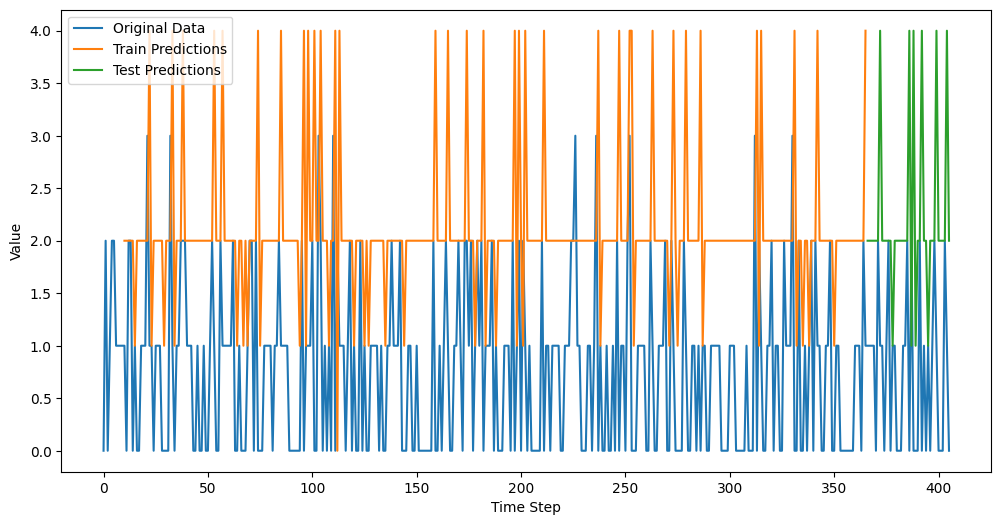

In [14]:
### 최종 결과 입니다. (113789)
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113789
predict_scale = 10000000
predict_round = 7
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

Current Step #02 [now = 2025-06-19 19:22:12.534588]
Current Step #04 [now = 2025-06-19 19:22:12.535626]
Current Step #06 [now = 2025-06-19 19:22:12.536080]
Current Step #08 [now = 2025-06-19 19:22:12.536191]
Current Step #10 [now = 2025-06-19 19:22:12.536225]
Current Step #12 [now = 2025-06-19 19:22:12.613890]
Current Step #14 [now = 2025-06-19 19:22:49.675695]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Current Step #16 [now = 2025-06-19 19:22:50.363112]
Current Step #17 [now = 2025-06-19 19:22:50.365874]
Current Step #18 [now = 2025-06-19 19:22:50.366395]
Current Step #20 [now = 2025-06-19 19:22:50.374010]
Train RMSE: 8.638657563208652
Test RMSE: 8.494115610232768


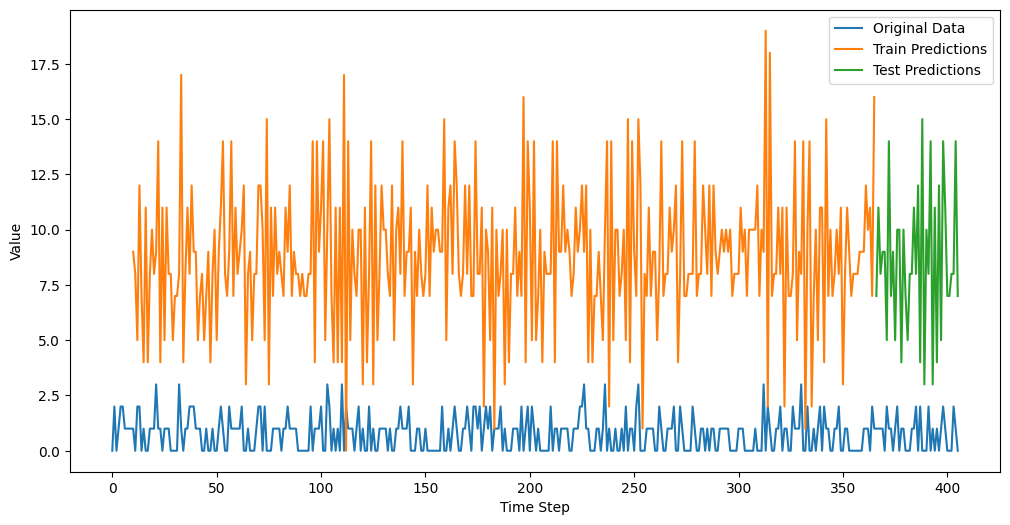

In [15]:
### 최종 결과 입니다. (113789)
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113700
predict_scale = 10000000
predict_round = 7
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

Current Step #02 [now = 2025-06-19 19:30:23.872899]
Current Step #04 [now = 2025-06-19 19:30:23.874996]
Current Step #06 [now = 2025-06-19 19:30:23.875898]
Current Step #08 [now = 2025-06-19 19:30:23.876002]
Current Step #10 [now = 2025-06-19 19:30:23.876021]
Current Step #12 [now = 2025-06-19 19:30:24.031375]
Current Step #14 [now = 2025-06-19 19:31:01.295008]
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Current Step #16 [now = 2025-06-19 19:31:01.933355]
Current Step #17 [now = 2025-06-19 19:31:01.935973]
Current Step #18 [now = 2025-06-19 19:31:01.936536]
Current Step #20 [now = 2025-06-19 19:31:01.939053]
Train RMSE: 1.3626230487679665
Test RMSE: 1.4142135623730951
random_state = 113789


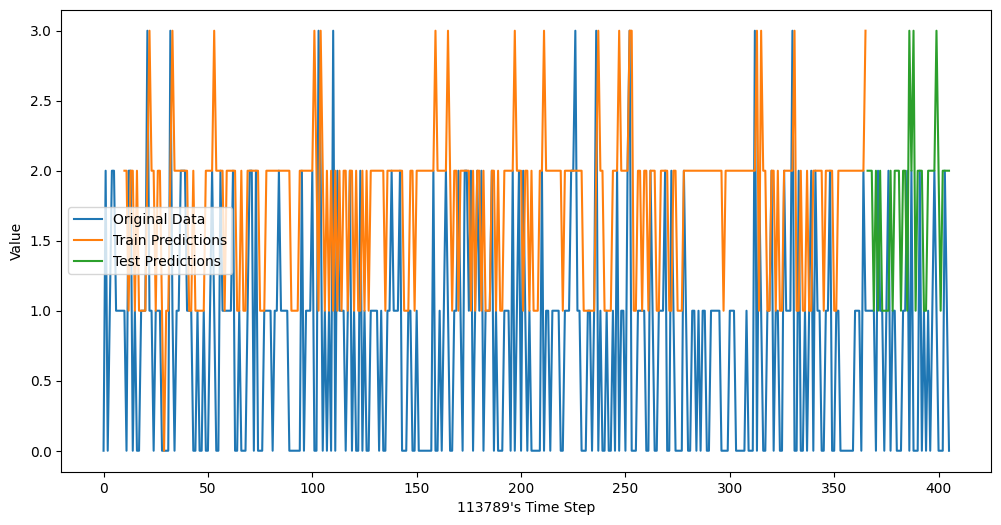

In [22]:
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113705
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

In [39]:
version = "T_01_11"
db_file_path = '../db/metrics.db'
random_state = 113708
# predict_scale = 10000000
predict_scale = 10000000
predict_round = 8
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

Current Step #02 [now = 2025-06-19 20:09:13.152516]
Current Step #04 [now = 2025-06-19 20:09:13.157710]
Current Step #06 [now = 2025-06-19 20:09:13.160349]
Current Step #08 [now = 2025-06-19 20:09:13.160516]
X_last = [array([0.])]
X_test = [[[0. ]
  [0. ]
  [0. ]
  [0. ]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]]

 [[0. ]
  [0. ]
  [0. ]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]]

 [[0. ]
  [0. ]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]]

 [[0. ]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]]

 [[0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0.1]]

 [[0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0. ]]

 [[0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]]

 [[0. ]
  [0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]]

 [[0.2]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0.1]
  [0. ]
  [0.2]
  [0.1]
  [0.1]]

 [[0.1]
  [0.1]
  [0.1

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]